In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Executive Summary

This is a study of the paper: https://arxiv.org/pdf/2311.07509 , authored by the company data.world

All the data are cloned from https://github.com/datadotworld/cwd-benchmark-data 

I compare 4 ways of generating database queries from English questions:
1. from vanila DDL of relational model without any comments. The DDL file is about 150 lines ling. LLM soly depends on the table and field naming convention and entity relationships.
2. same DDL with minimal comments added (<20 lines of comments)
3. using R2RML instead of DDL to generate the SQL queries.
4. using OWL to generate the SPARQL queries, then use R2RML to convert the SPARQL into SQL

Methods 1 and 4 were the approaches taken by the data.world paper. The other 2 were exploratory for my own learning. 

Various metrics were measured:
* Time duration for LLM to generate the queries
* Number of tokens from the input files fed to the LLM. This is measured by copying the file into https://tiktokenizer.vercel.app/ using the GPT4 tokeniser.
* Accuracy of the generated queries. The query accuracy is determined by comparing the above output SQL queries against standard answer provided by the dataset. 

# Prepare Data

Convert TTL files into pandas dataframes for easy analysis.

In [1]:
from ttl_to_dataframe import read_ttl_to_dataframe, analyze_ttl_content

# Load TTL file into structured DataFrames
df_triples, df_structured = read_ttl_to_dataframe("data/ACME_Insurance/investigation/acme-benchmark.ttl")

# Analyze the content
analysis = analyze_ttl_content(df_triples, df_structured)

print(f"Total triples: {analysis['total_triples']}")
print(f"Entity types: {analysis['entity_types']}")

Total triples: 950
Entity types: {'SqlQuery': 45, 'SparqlQuery': 44, 'Inquiry': 44, 'Investigation': 1}


In [2]:
df_structured['entity_type'].unique()

array(['SqlQuery', 'SparqlQuery', 'Inquiry', 'Investigation'],
      dtype=object)

# Build DB

create an in-memory ralational database from the CSV files downloaded from data.world github repo.

In [3]:
import duckdb
import pandas as pd

import os

csv_dir = "data/ACME_Insurance/data"
csv_files = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]

# Connect to DuckDB (in-memory)
conn = duckdb.connect(':memory:')

# Create views for easier querying
for csv in csv_files:
    csv_file = f"{csv_dir}/{csv}"
    table_name = csv.split('.')[0]
    conn.execute(f"CREATE VIEW {table_name} AS SELECT * FROM read_csv_auto('{csv_file}')")

In [ ]:
# Now query like regular tables
result = conn.execute("""
SELECT DISTINCT 
  '' || phr.party_identifier AS policyHolder,
  '' || p.policy_identifier AS policy,
  '' || prm.policy_amount_identifier AS premium
FROM policy p
JOIN policy_coverage_detail pcd ON pcd.policy_identifier = p.policy_identifier
JOIN policy_amount pa ON pa.policy_coverage_detail_identifier = pcd.policy_coverage_detail_identifier
JOIN premium prm ON pa.policy_amount_identifier = prm.policy_amount_identifier
JOIN (
    SELECT DISTINCT policy.policy_identifier, party_identifier
    FROM agreement_party_role
    JOIN policy ON agreement_party_role.agreement_identifier = policy.policy_identifier
    WHERE agreement_party_role.party_role_code = 'PH'
) phr ON phr.policy_identifier = p.policy_identifier
""").fetchdf()

result

,policyHolder,policy,premium
0,1,1,6
1,1,1,8
2,1,1,2
3,1,2,12
4,1,1,4
5,1,1,10


In [ ]:
conn.close()

# SQL

Prepare the SQL dataset.
There are some errors in the data.world dataset, I had to manually fix and replace them.

In [7]:
df_sql = df_structured[df_structured['entity_type']=='SqlQuery']
df_sql = df_sql[['description', 'content']]
df_sql.columns = ['question', 'sql']

# fix syntax error of SQL
df_sql.loc[7, 'sql'] =  """
select policy_number, avg(DATE_DIFF('day', claim_open_date, claim_close_date ))
from claim 
inner join claim_coverage on claim.claim_identifier = claim_coverage.claim_identifier
inner join policy_coverage_detail on claim_coverage.policy_coverage_detail_identifier = policy_coverage_detail.policy_coverage_detail_identifier
inner join policy on policy.policy_identifier = policy_coverage_detail.policy_identifier
where claim_close_date IS NOT NULL
group by policy_number
"""

df_sql.loc[12, 'sql'] = """
SELECT
    apr2.party_identifier as AgentID,
    apr1.party_identifier as PolicyHolderID, 
    policy_number,
    policy_amount as premium, 
    catastrophe_name,
    company_claim_number,
    ca_lp.claim_amount as Loss_Payment_Amount
FROM
    Claim
    inner join catastrophe on claim.catastrophe_identifier = catastrophe.catastrophe_identifier
    inner join claim_amount ca_lp on claim.claim_identifier = ca_lp.claim_identifier
    inner JOIN loss_payment ON ca_lp.claim_amount_identifier = loss_payment.claim_amount_identifier
    inner join claim_amount ca_lr on claim.claim_identifier = ca_lr.claim_identifier
    inner JOIN loss_reserve ON ca_lr.claim_amount_identifier = loss_reserve.claim_amount_identifier
    inner join claim_amount ca_ep on claim.claim_identifier = ca_ep.claim_identifier
    inner JOIN expense_payment ON ca_ep.claim_amount_identifier = expense_payment.claim_amount_identifier
    inner join claim_amount ca_er on claim.claim_identifier = ca_er.claim_identifier
    inner JOIN expense_reserve ON ca_er.claim_amount_identifier = expense_reserve.claim_amount_identifier
    inner join claim_coverage on claim.claim_identifier = claim_coverage.claim_identifier
    inner join policy_coverage_detail on claim_coverage.policy_coverage_detail_identifier = policy_coverage_detail.policy_coverage_detail_identifier
    inner join policy on policy.policy_identifier = policy_coverage_detail.policy_identifier
    inner join policy_amount on policy_coverage_detail.policy_coverage_detail_identifier = policy_amount.policy_coverage_detail_identifier
    inner join  agreement_party_role apr1 on apr1.agreement_identifier = policy.policy_identifier
    inner join  agreement_party_role apr2 on apr2.agreement_identifier = policy.policy_identifier
    inner join premium on premium.policy_amount_identifier = policy_amount.policy_amount_identifier
where apr1.party_role_code = 'PH' and apr2.party_role_code = 'AG'
"""

df_sql.head()

,question,sql
0,How many claims do we have?,SELECT COUNT(*) AS NoOfClaims\nFROM claim
1,What are the expense payment amount of all cla...,"SELECT\n company_claim_number,\n claim_a..."
2,Return agents and the policy they have sold th...,"SELECT\n party_identifier as AgentID,\n ..."
3,"What is the total loss amounts, which is the s...","SELECT\n company_claim_number,\n (ca_lp...."
4,"What are the loss payment, loss reserve, expen...","SELECT\n apr2.party_identifier as AgentID,\..."


## Generate

In [ ]:
import utils
import time
from typing import List, Tuple

def gen_sql_from_ddl(ddl: str)->Tuple[List[str], List[float]]:
    """For each questions in df_sql dataframe, use the DDL passed in as context to generate the SQL query
    using LLM. Return the list of SQL queries, and the list of durations, one for each question and answer.
    
    Args:
        ddl (str): the DDL statement that define the relational database

    Returns:
        queries (list[str]): list of SQL queries based on the questions in df_sql
        durations (list[float]): list of durations (in seconds) that the LLM took to generate the SQL queries
    """
    queries, durations = [], []
    for row in df_sql.itertuples(index=False):
        question = row.question

        start_time = time.perf_counter()
        PROMPT = f"""
Given the database described by the following DDL:
```sql
{ddl}
```
Write a SQL query that answers the following question. Do not explain the query. return just the query, so it can be run
verbatim from your response. Do not use code fencing. The target database is DuckDB, so use its SQL syntax.
Here's the question:
{question}
        """

        messages = [{"role": "user", "content": PROMPT}
                    ]
        response = utils.client.chat.completions.create(
            # model='guardrails-bedrock-claude-4-sonnet', 
            # model = 'guardrails-o3-mini_v2025-01-31_EASTUS2', 
            model=utils.CHAT_MODEL,
            messages=messages)
        queries.append(response.choices[0].message.content)

        end_time = time.perf_counter()
        durations.append(end_time - start_time)
        
    return queries, durations

### using vanila DDL
The DDL file has 1505 tokens (using gpt4's tokeniser).

In [8]:
with open('data/ACME_Insurance/DDL/ACME_small.ddl', 'r') as f:
    ddl = f.read()

queries, durations = gen_sql_from_ddl(ddl)

In [11]:
df_sql['sql_ddl'] = queries
df_sql['dur_ddl'] = durations

In [ ]:
df_sql.to_excel('output/sql_results.xlsx', index=False)

### using commented DDL
Number of tokens of the commented DDL file is 2077.

In [13]:
import utils 

with open('data/ACME_Insurance/DDL/ACME_comented.ddl', 'r') as f:
    ddl = f.read()

queries, durations = gen_sql_from_ddl(ddl)
df_sql['sql_ddlcmt'] = queries
df_sql['dur_ddlcmt'] = durations

In [14]:
df_sql.to_excel('output/sql_results.xlsx', index=False)

## Evaluate

In [ ]:
from typing import List, Tuple

def run_sqls(column_name:str)->Tuple[List[str], List[str]]:
    """execute the standard answer and generated SQL queries in df_sql and return both lists of results
    Args:
        column_name (str): df_sql column name of the generated SQL queries

    Returns:
        results_1 (list[str]): SQL output from standard answer SQL statements
        results_2 (list[str]): SQL output from generated SQL statements
    """
    results_1, results_2 = [], []
    # for row in df_sql.itertuples(index=False):
    for idx, row in df_sql.iterrows():
        sql = row['sql']
        answer = row[column_name]

        try:
            result1 = conn.execute(sql).fetch_df()
        except Exception as e:
            result1 = pd.DataFrame([f"error: {e}"])
        
        try:
            result2 = conn.execute(answer).fetch_df()
        except Exception as e:
            result2 = pd.DataFrame([f"error: {e}"])
            
        results_1.append(result1)
        results_2.append(result2)

    return results_1, results_2

In [15]:
df_sql = pd.read_excel('output/sql_results.xlsx')

In [16]:
df_sql.head()

,question,sql,sql_ddl,dur_ddl,sql_ddlcmt,dur_ddlcmt
0,How many claims do we have?,SELECT COUNT(*) AS NoOfClaims\nFROM claim,SELECT COUNT(*) AS claim_count FROM Claim;,1.745807,SELECT COUNT(*) AS claim_count FROM Claim;,1.179061
1,What are the expense payment amount of all cla...,"SELECT\n company_claim_number,\n claim_a...","select \n c.Company_Claim_Number,\n sum(ca.C...",1.056521,"select \n c.Company_Claim_Number,\n sum(...",1.021215
2,Return agents and the policy they have sold th...,"SELECT\n party_identifier as AgentID,\n ...","SELECT\n p.Policy_Identifier,\n p.Policy...",1.952906,"SELECT\n a.Policy_Identifier,\n p.Policy_Num...",2.316528
3,"What is the total loss amounts, which is the s...","SELECT\n company_claim_number,\n (ca_lp....","select\n c.Company_Claim_Number,\n sum(coale...",1.436160,"select\n c.Company_Claim_Number,\n sum(ca.Cl...",1.984121
4,"What are the loss payment, loss reserve, expen...","SELECT\n apr2.party_identifier as AgentID,\...",SELECT\n c.Company_Claim_Number AS Claim_Nu...,5.623636,"SELECT \n c.Company_Claim_Number,\n p.Po...",5.838963


### Vanila DDL SQL queries

In [32]:
results_1, results_2 = run_sqls('sql_ddl')

In [275]:
# 37 is arguable
correct_row_idxs = [0, 1, 3, 6, 8, 9, 10, 13, 14, 16, 18, 27, 29, 30, 31, 33, 37, 38, 40, 41, 42]
print(f"correct anwers: {len(correct_row_idxs)/len(df_sql)*100}%")

correct anwers: 46.666666666666664%


In [35]:
idx=16
results_1[idx], results_2[idx]

(   Policy_Number  Company_Claim_Number Catastrophe_Name  Loss
 0    31003000336              12312701             Fire  4600
 1    31003000336              12312702             Fire  9000,
    Company_Claim_Number Catastrophe_Name  Policy_Number  Loss_Payment_Amount  \
 0              12312701             Fire    31003000336               1200.0   
 1              12312702             Fire    31003000336               2300.0   
 
    Loss_Reserve_Amount  Expense_Payment_Amount  Expense_Reserve_Amount  \
 0               1000.0                  1300.0                  1100.0   
 1               2100.0                  2400.0                  2200.0   
 
    Total_Loss_Amount  
 0             4600.0  
 1             9000.0  )

### Commented DDL SQL queries

In [36]:
results_1, results_2 = run_sqls('sql_ddlcmt')

In [197]:
correct_row_idxs = [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22, 24, 26, 27, 28, 29, 
                    30, 31, 32, 33, 36, 37, 38, 40, 41, 42, 43]
print(f"correct anwers: {len(correct_row_idxs)/len(df_sql)*100}%")

correct anwers: 75.55555555555556%


In [37]:
idx=44
results_1[idx], results_2[idx]

(   AgentID  Policy_Number  Company_Claim_Number  Expense_Reserve_Amount
 0        2    31003000336              12312702                    2200
 1        2    31003000336              12312701                    1100,
    Agent_Identifier  Policy_Number  Company_Claim_Number  \
 0                 2    31003000336              12312701   
 1                 2    31003000337              12312702   
 
    Expense_Reserve_Amount  
 0                    1100  
 1                    2200  )

# SparQL

In [39]:
df_sparql = df_structured[df_structured['entity_type']=='SparqlQuery']
df_sparql = df_sparql[['description', 'content']]
df_sparql.columns = ['question', 'sparql']
df_sparql.head()

,question,sparql
45,"What are the loss payment, loss reserve, expen...",PREFIX : <https://myinsurancecompany.linked.da...
46,How many policies do we have?,PREFIX : <https://myinsurancecompany.linked.da...
47,"What are the loss payment, loss reserve, expen...",PREFIX : <https://myinsurancecompany.linked.da...
48,What is the premium amount of all policies by ...,PREFIX : <https://myinsurancecompany.linked.da...
49,Return all the policies and the agents that so...,PREFIX : <https://myinsurancecompany.linked.da...


## Generate
### SPARQL
44 Q&A.
The TTL file is about 2.76K tokens.

In [41]:
import time
import utils 

with open('data/ACME_Insurance/ontology/insurance.ttl', 'r') as f:
    ttl = f.read()

queries, durations = [], []
for row in df_sparql.itertuples(index=False):
    question = row.question

    start_time = time.perf_counter()
    PROMPT = f"""
Given the OWL model described in the following TTL file:
```ttl
{ttl}
```
Write a SPARQL query that answers the question. The data for your query is available in a SERVICE identified by
:mapped. Do not explain the query. return just the query, so it can be run verbatim from your response.
Do not include any code fencing in the response.
Here's the question:
{question}
    """

    messages = [{"role": "user", "content": PROMPT}
                ]
    response = utils.client.chat.completions.create(
        # model='guardrails-bedrock-claude-4-sonnet', 
        # model = 'guardrails-o3-mini_v2025-01-31_EASTUS2', 
        model=utils.CHAT_MODEL,
        messages=messages)
    queries.append(response.choices[0].message.content)

    end_time = time.perf_counter()
    durations.append(end_time - start_time)
    
df_sparql['sparql_gen'] = queries
df_sparql['sparql_gen_dur'] = durations

In [42]:
df_sparql.to_excel('output/sparql_results.xlsx', index=False)

### SQL from SPARQL with R2RML

Now that we have go the generated SPARQL, we can convert it into SQL using LLM.
I am using LLM because all other attempts by using various python libraries failed.

In [44]:
import time
import utils 

with open('data/ACME_Insurance/data/data.world_P&C_Insurance_Ontology_V1.r2rml', 'r') as f:
    r2rml = f.read()

queries, durations = [], []
for row in df_sparql.itertuples(index=False):
    answer = row.sparql_gen

    start_time = time.perf_counter()
    PROMPT = f"""
Given the R2RML model described in the following TTL file:
```ttl
{r2rml}
```
Convert the following SPARQL query into a SQL query which will yield equivalent query results as the SPARQL query.
In the SQL query use table name only and ignore any schema name or namespaces.
Do not explain the query. return just the query, so it can be run verbatim from your response.
Do not include any code fencing in the response.
Here's the SPARQL query:
{answer}
    """

    messages = [{"role": "user", "content": PROMPT}
                ]
    response = utils.client.chat.completions.create(
        # model='guardrails-bedrock-claude-4-sonnet', 
        # model = 'guardrails-o3-mini_v2025-01-31_EASTUS2', 
        model=utils.CHAT_MODEL,
        messages=messages)
    queries.append(response.choices[0].message.content)

    end_time = time.perf_counter()
    durations.append(end_time - start_time)

df_sparql['sql_sparql'] = queries
df_sparql['sql_sparql_dur'] = durations

In [45]:
df_sparql.to_excel('output/sparql_results.xlsx', index=False)

### SQL with R2RML

This is an experiment to generate the SQL directly from R2RML.

The R2RML file has 10280 tokens.

In [46]:
import time
import utils 

with open('data/ACME_Insurance/data/data.world_P&C_Insurance_Ontology_V1.r2rml', 'r') as f:
    r2rml = f.read()

queries, durations = [], []
for row in df_sparql.itertuples(index=False):
    question = row.question

    start_time = time.perf_counter()
    PROMPT = f"""
Given the R2RML model described in the following TTL file:
```ttl
{r2rml}
```
Write a SQL query that answers the question. Use the R2RML file to reverse-engineer the relational data model. 
Then use that relational data model for the SQL query that answers the question. 
In the SQL query use table name only and ignore any schema name or namespaces.
Do not explain the query. return just the query, so it can be run verbatim from your response.
Do not include any code fencing in the response.
Here's the question:
{question}
    """

    messages = [{"role": "user", "content": PROMPT}
                ]
    response = utils.client.chat.completions.create(
        # model='guardrails-bedrock-claude-4-sonnet', 
        # model = 'guardrails-o3-mini_v2025-01-31_EASTUS2', 
        model=utils.CHAT_MODEL,
        messages=messages)
    queries.append(response.choices[0].message.content)

    end_time = time.perf_counter()
    durations.append(end_time - start_time)

df_sparql['sql_r2rml'] = queries
df_sparql['sql_r2rml_dur'] = durations

In [47]:
df_sparql.to_excel('output/sparql_results.xlsx', index=False)

## Evaluate

In [ ]:
from typing import List, Tuple

def run_sqls_for_sparql(column_name: str)->Tuple[List[str], List[str]]:
    """Execute the SQL queries on provided column_name one by one from df_sparql dataframe.
    It also cross-reference df_sql for the standard-answer SQL and run those as well.
    The standard-answer SQL results are stored in results_1, the column_name's SQL query results in results_2

    Args:
        column_name (str): column name of the df_sparql containing the SQL queries

    Returns:
        results_1 (list[str]): outputs of the standard answer SQL queries
        results_2 (list[str]): outputs of the SQL queries from column_name of df_sparql dataframe
    """
    results_1, results_2 = [], []
    for idx, row in df_sparql.iterrows():
        question = row['question'].strip().replace('  ', ' ')
        # print("\n", question)

        sql = df_sql[df_sql['question'].str.strip().replace('  ', ' ') == question].iloc[0]['sql']
        answer = row[column_name]

        try:
            result1 = conn.execute(sql).fetch_df()
        except Exception as e:
            result1 = pd.DataFrame([f"error: {e}"])
        
        try:
            result2 = conn.execute(answer).fetch_df()
        except Exception as e:
            result2 = pd.DataFrame([f"error: {e}"])
            
        results_1.append(result1)
        results_2.append(result2)
    return results_1, results_2

### Compare SQL (from R2RML) results

In [49]:
results_1, results_2 = run_sqls_for_sparql('sql_r2rml')

In [98]:
correct_row_idxs = [0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 18, 22, 24, 25, 26, 28, 30, 31, 35, 37, 39, 41]
print(f"correct anwers: {len(correct_row_idxs)/len(df_sql)*100}%")

correct anwers: 48.888888888888886%


In [97]:
idx=44
results_1[idx], results_2[idx]

IndexError: list index out of range

### Compare SQL (from SPARQL) results

In [99]:
results_1, results_2 = run_sqls_for_sparql('sql_sparql')

In [ ]:
# 40 is arguable
correct_row_idxs = [0, 1, 2, 3, 4, 5, 7, 8, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 
                    30, 31, 32, 34, 35, 39, 40, 41, 42, 43]
print(f"correct anwers: {len(correct_row_idxs)/len(df_sql)*100}%")

correct anwers: 73.33333333333333%


In [115]:
idx=14
results_1[idx], results_2[idx]

(   AgentID  Policy_Number  Company_Claim_Number  Loss_Reserve_Amount
 0        2    31003000336              12312702                 2100
 1        2    31003000336              12312701                 1000,
    agentId  Policy_Number  claimNumber  lossReserveAmount
 0        2    31003000336     12312702               2100
 1        2    31003000336     12312701               1000)

# Plot Comparison

In [1]:
import pandas as pd

df_sparql = pd.read_excel('output/sparql_results.xlsx')
df_sql = pd.read_excel('output/sql_results.xlsx')

In [2]:
# build combined df from df_sql and df_sparql
df_combined = df_sparql[['question', 'sparql_gen_dur', 'sql_r2rml_dur', 'sql_sparql_dur']]
df_combined['sql_ddl_dur'] = pd.NA
df_combined['sql_ddlcmt_dur'] = None

for row in df_combined.itertuples():
    question = row.question.strip().replace('  ', ' ')

    sql_row = df_sql[df_sql['question'].str.strip().replace('  ', ' ') == question]
    df_combined.loc[row[0], 'sql_ddl_dur'] = sql_row.iloc[0].dur_ddl
    df_combined.loc[row[0], 'sql_ddlcmt_dur'] = sql_row.iloc[0].dur_ddlcmt
    

C:\Users\lawr1\AppData\Local\Temp\ipykernel_19824\3557366030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['sql_ddl_dur'] = pd.NA
C:\Users\lawr1\AppData\Local\Temp\ipykernel_19824\3557366030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['sql_ddlcmt_dur'] = None


In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Sample data
categories = ['DDL', 'DDL & comments', 'R2RML', 'RDF & R2RML']
values1 = [46.67, 75.56, 48.89, 73.33] # accuracy
values2 = [1505, 2077, 10280, 2762] # num tokens
values2_1 = [0, 0, 0, 10280+2762]
values3 = [df_combined['sql_ddl_dur'].sum(), 
           df_combined['sql_ddlcmt_dur'].sum(), 
           df_combined['sql_r2rml_dur'].sum(),
           df_combined['sparql_gen_dur'].sum() 
           ] # duration (s)
values3_1 = [0,0,0, df_combined['sparql_gen_dur'].sum() + df_combined['sql_sparql_dur'].sum()]

# Add first bar chart
fig.add_trace(
    go.Bar(x=categories, y=values1, name="Accuracy (%)", offsetgroup=1,
           marker_color='blue', opacity=0.7, width=0.3),
    secondary_y=False,
)
# Add third bar chart
fig.add_trace(
    go.Bar(x=categories, y=values3, name="Duration (s)", offsetgroup=0,
           marker_color='purple', opacity=0.7),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=categories, y=values3_1, name="Duration (s)", offsetgroup=0,
           marker_color='purple', opacity=0.4),
    secondary_y=False,
)

# Add second bar chart
fig.add_trace(
    go.Bar(x=categories, y=values2, name="No. tokens", offsetgroup=2,
           marker_color='red', opacity=0.7),
    secondary_y=True,
)
fig.add_trace(
    go.Bar(x=categories, y=values2_1, name="No. tokens", offsetgroup=2,
           marker_color='red', opacity=0.4),
    secondary_y=True,
)

# Set y-axes titles
fig.update_yaxes(title_text="Accuracy (%), Duration (s)", secondary_y=False, color='blue')
fig.update_yaxes(title_text="No. tokens", secondary_y=True, color='red')

# Set x-axis title
fig.update_xaxes(title_text="Categories")

fig.update_layout(title="Comparison", barmode='group',
                  bargap=0.1, bargroupgap=0.1)
fig.show()

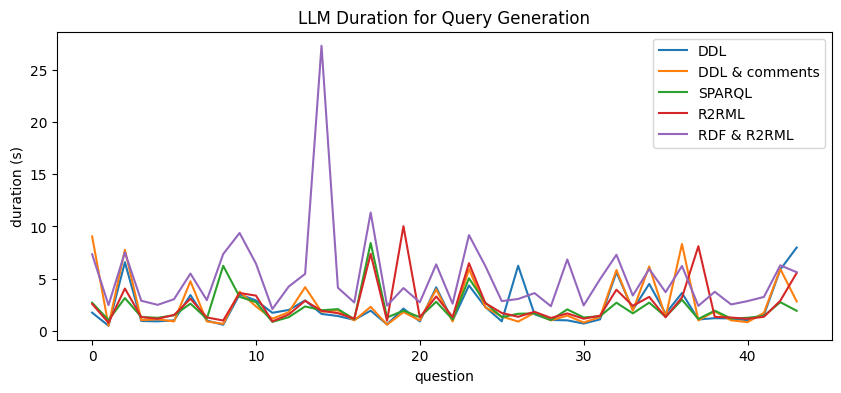

In [20]:
import matplotlib.pyplot as plt
categories = ['DDL', 'DDL & comments', 'SPARQL', 'R2RML']
column_names = ['sql_ddl_dur', 'sql_ddlcmt_dur', 'sparql_gen_dur', 'sql_r2rml_dur' ]

plt.figure(figsize=(10,4))
for col, cat in zip(column_names, categories):
    plt.plot(range(len(df_combined)), df_combined[col], label=cat)
plt.plot(range(len(df_combined)), df_combined['sparql_gen_dur'] + df_combined['sql_sparql_dur'], 
         label='RDF & R2RML')
    
plt.legend()
plt.title('LLM Duration for Query Generation')
plt.ylabel('duration (s)')
plt.xlabel('question')
plt.show()

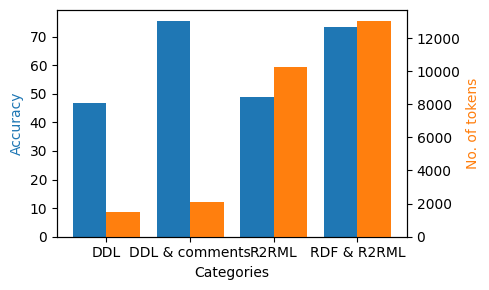

In [14]:
import matplotlib.pyplot as plt

categories = ['DDL', 'DDL & comments', 'R2RML', 'RDF & R2RML']
color1, color2 = 'tab:blue', 'tab:orange'
fig, ax1 = plt.subplots(figsize=(5, 3))
ax1.bar([x - 0.2 for x in range(len(categories))],
        [46.67, 75.56, 48.89, 73.33], width=0.4, color=color1)
ax1.set_xlabel('Categories')
ax1.set_ylabel('Accuracy', color=color1)
ax1.set_xticks(range(len(categories)), categories)

ax2 = ax1.twinx()
ax2.bar([x + 0.2 for x in range(len(categories))],
        [1505, 2077, 10280, 10280+2762], width=0.4, color=color2)
ax2.set_ylabel("No. of tokens", color=color2)

plt.tight_layout()
plt.show()

## Ontology

In [12]:
from ttl_to_dataframe import read_ttl_to_dataframe, analyze_ttl_content

# Load TTL file into structured DataFrames
df_triples, df_structured = read_ttl_to_dataframe("data/ACME_Insurance/ontology/insurance.ttl")

# Analyze the content
analysis = analyze_ttl_content(df_triples, df_structured)

print(f"Total triples: {analysis['total_triples']}")
print(f"Entity types: {analysis['entity_types']}")

Total triples: 164
Entity types: {}


In [14]:
df_structured

""
